In [1152]:
# import standard libraries
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [1153]:
# import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [1154]:
# Add OOM errrors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

MOVE DATASET FROM LFW TO DATA FOLDER

In [1155]:
# Set up paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [1156]:
# Make directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [1157]:
# for directory in os.listdir('lfw'): # loop directory
#   for file in os.listdir(os.path.join('lfw', directory)): # loop files
#     EX_PATH = os.path.join('lfw', directory, file)
#     NEW_PATH = os.path.join(NEG_PATH, file)
#     os.replace(EX_PATH, NEW_PATH)

COLLECT POSITIVE AND ANCHOR CLASSES

In [1158]:
import uuid

In [1159]:
# uuid?? -> "??" Used for library information tracking 

In [1160]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#   ret, frame  = cap.read()
#   frame = frame[120: 120 + 250, 200:200 + 250, :]
#   cv2.imshow('Image Collection', frame)

#   # Collect Anchor Images
#   if cv2.waitKey(1) & 0xFF == ord('a'):
#     # Create unique file path
#     imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#     # Write out anchor image
#     cv2.imwrite(imgname, frame)

#   # Collect Positive Images
#   if cv2.waitKey(1) & 0xFF == ord('p'):
#     # Create unique file path
#     imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#     # Write out anchor image
#     cv2.imwrite(imgname, frame)

#   # Breaking gracefully
#   if cv2.waitKey(1) & 0xFF == ord('q'):
#     break
# cap.release()
# cv2.destroyAllWindows()

LOAD AND PREPROCESS IMAGES

In [1161]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

In [1162]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\9f4053fd-9120-11ef-814e-fb89cd63b556.jpg'


PREPROCESSING

In [1163]:
def preprocess(file_path):
  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)

  # Preprocessing steps - resize image size from 250 x 250 to 100 x 100
  img = tf.image.resize(img, (100, 100))

  # Scale image from 0 to 1
  img = img / 255.0
  return img

In [1164]:
img = preprocess('data\\anchor\\9f580497-9120-11ef-babf-fb89cd63b556.jpg')
img.numpy().min()
img.numpy().max()

1.0

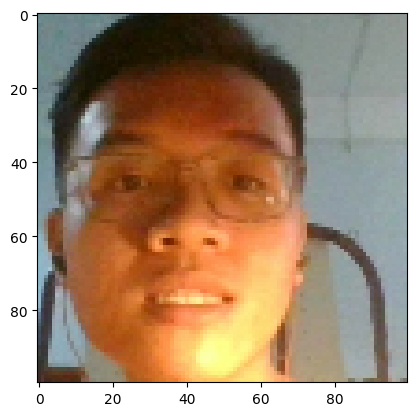

In [1165]:
plt.imshow(img)

CREATE LABELED DATASET

In [1166]:
# (anchor, positive) => [1,1,1,1,1]
# (anchor, negative) => [0,0,0,0,0]

In [1167]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [1168]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [1169]:
samples = data.as_numpy_iterator()

In [1170]:
example = samples.next()

BUILD TRAIN AND TEST PARTITION

In [1171]:
def preprocess_twin(input_img, validation_img, label):
  return (preprocess(input_img), preprocess(validation_img), label)

In [1172]:
# * is used for unpacking value inside example
res = preprocess_twin(*example)
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.38308823, 0.46544117, 0.485049  ],
         [0.36495098, 0.45931372, 0.475     ],
         [0.34436274, 0.44681373, 0.45367646],
         ...,
         [0.49436274, 0.5375    , 0.52181375],
         [0.50710785, 0.5502451 , 0.53455883],
         [0.5147059 , 0.55      , 0.5382353 ]],
 
        [[0.3852941 , 0.46078432, 0.4852941 ],
         [0.3747549 , 0.45931372, 0.47818628],
         [0.34754902, 0.4387255 , 0.4495098 ],
         ...,
         [0.50686276, 0.5480392 , 0.53333336],
         [0.5132353 , 0.5477941 , 0.5360294 ],
         [0.51740193, 0.5497549 , 0.5389706 ]],
 
        [[0.37132353, 0.45857844, 0.48308823],
         [0.35784313, 0.4490196 , 0.46568626],
         [0.3627451 , 0.44730392, 0.46029413],
         ...,
         [0.5352941 , 0.5617647 , 0.5529412 ],
         [0.53063726, 0.55490196, 0.5468137 ],
         [0.5352941 , 0.5588235 , 0.5509804 ]],
 
        ...,
 
        [[0.22892156, 0.17058824

In [1173]:
# res[0] -> anchor
# res[1] -> positive
# res[2] -> label

In [1174]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [1175]:
# Mixed up the data to prevent overfitting
sample = data.as_numpy_iterator()
sample.next()[2]

0.0

In [1176]:
# Training partition
train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
# Prevent bottlenecking
train_data = train_data.prefetch(8)

In [1177]:
sample = train_data.as_numpy_iterator()

In [1178]:
# Number of batches 
len(sample.next()[0])

16

In [1179]:
# Testing partition
test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

MODEL ENGINEERING

In [1180]:
# First parameter is the batch size 
input_img = Input(shape=(100, 100, 3), name='input_img')

In [1181]:
c1 = Conv2D(64, (10,10), activation='relu')(input_img)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [1182]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [1183]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [1184]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [1185]:
model =  Model(inputs=[input_img], outputs=[d1], name='embedding')

In [1186]:
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [1187]:
def make_embedding():
  inp = Input(shape=(100, 100, 3), name='input_image')
  # First Block
  c1 = Conv2D(64, (10,10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  # Second Block
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  # Third Block
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  # Final Embedding block
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=inp, outputs=d1, name='embedding')

In [1188]:
embedding = make_embedding()

In [1189]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 20, 20, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 9, 9, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_135 (Conv2D)             │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

BUILD DISTANCE LAYER

In [1190]:
# Siamese L1 Distance class
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()
  
  # Similarity calculations
  def call(self, inputs):
    # print(len(inputs))
    input_embedding, validation_embedding = inputs
    return tf.math.abs(input_embedding - validation_embedding)

In [1191]:
l1 = L1Dist()

MAKE SIAMESE MODEL

In [1192]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [1193]:
input_embedding = embedding(input_image)
validation_embedding = embedding(validation_image)

In [1194]:
siamese_layer = L1Dist()

In [1195]:
# Correctly call the siamese_layer with input tensors
distances = siamese_layer([input_embedding, validation_embedding])

In [1196]:
classifier = Dense(1, activation='sigmoid')(distances)

In [1197]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_437>

In [1198]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese_network')

In [1199]:
siamese_network.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_49 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_49[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [1200]:
def make_siamese_model():

  # Anchor image input in the network
  input_image = Input(shape=(100, 100, 3), name='input_img')

  # Validation image in the network
  validation_image = Input(shape=(100, 100, 3), name='validation_img')

  siamese_layer = L1Dist()
  siamese_layer._name = 'distance' # naming layer -> pedantic
  distances = siamese_layer([embedding(input_image), embedding(validation_image)])

  # Classification layer
  classifier = Dense(1, activation='sigmoid')(distances)
  return Model(inputs=[input_image, validation_image], outputs=[classifier], name='SiameseNetwork')

In [1201]:
siamese_model = make_siamese_model()

In [1202]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_50 (L1Dist) │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_50[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

TRAINING 

LOSS AND OPTIMIZER

In [1203]:
# Can add parameter from_logits=True to the loss function in case the inputs are not normalized
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [1204]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

CHECK POINT

In [1205]:
# To reload from the checkpoint you can use model.load('path to check point) -> Load the pre trained weights into existing model
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

BUIDL TRAIN STEP FUNCTION

In [1206]:
test_batch = train_data.as_numpy_iterator()

In [1207]:
batch = test_batch.next()

In [1208]:
X = batch[:2]

In [1209]:
# (2,16,100, 100, 3) -> 2: anchor and pos/neg, 16: batch size, 100, 100, 3: image size
np.array(X).shape

(2, 16, 100, 100, 3)

In [1210]:
y = batch[2]

In [1211]:
@tf.function # Compile a function into a callable TensorFlow graph
def train_step(batch):
  
  # Record operations for automatic differentiation 
  with tf.GradientTape() as tape:
    # Get anchor and postive/negative image
    X = batch[:2]
    # Get label
    y = batch[2]

    # Forward pass
    yhat = siamese_model(X, training=True)
    # Calculate loss
    loss = binary_cross_loss(y, yhat)
  print(loss)

  # Calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  # Calculate updated weights and apply to the the siamese model
  '''
    Optimizer helps calculating and propagating the new weights using Adam's optimisation algorithm, a variant of gradient descent
  '''
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss


TRAINING LOOP

In [1212]:
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS + 1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    for idx, batch in enumerate(data):
      train_step(batch)
      progbar.update(idx + 1)
  
  # Save checkpoint
  if epoch % 10 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

TRAIN THE MODEL

In [1213]:
EPOCHS = 50 

In [1214]:
# train(train_data, EPOCHS)

EVALUATE MODEL

In [1215]:
# Import metrics  calculation
'''
  Precision demonstrates what proportion of positive identifications was actually correct
  Recall shows what proportion of actual positives was identified correctly
'''
from tensorflow.keras.metrics import Precision, Recall

In [1216]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [1217]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


array([[0.4984741 ],
       [0.49998412],
       [0.49981186],
       [0.49880815],
       [0.49905106],
       [0.49845272],
       [0.49782026],
       [0.49934506],
       [0.49924245],
       [0.4999337 ],
       [0.49887714],
       [0.4990977 ],
       [0.4994607 ],
       [0.4979031 ],
       [0.49834633],
       [0.49915746]], dtype=float32)

In [1218]:
# Post preprocessing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [1219]:
y_true

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [1220]:
# Creating a metric object 
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return result 
m.result().numpy()

0.0

In [1221]:
# Creating a metric object 
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return result 
m.result().numpy()

0.0

VISIUALIZE THE RESULTS

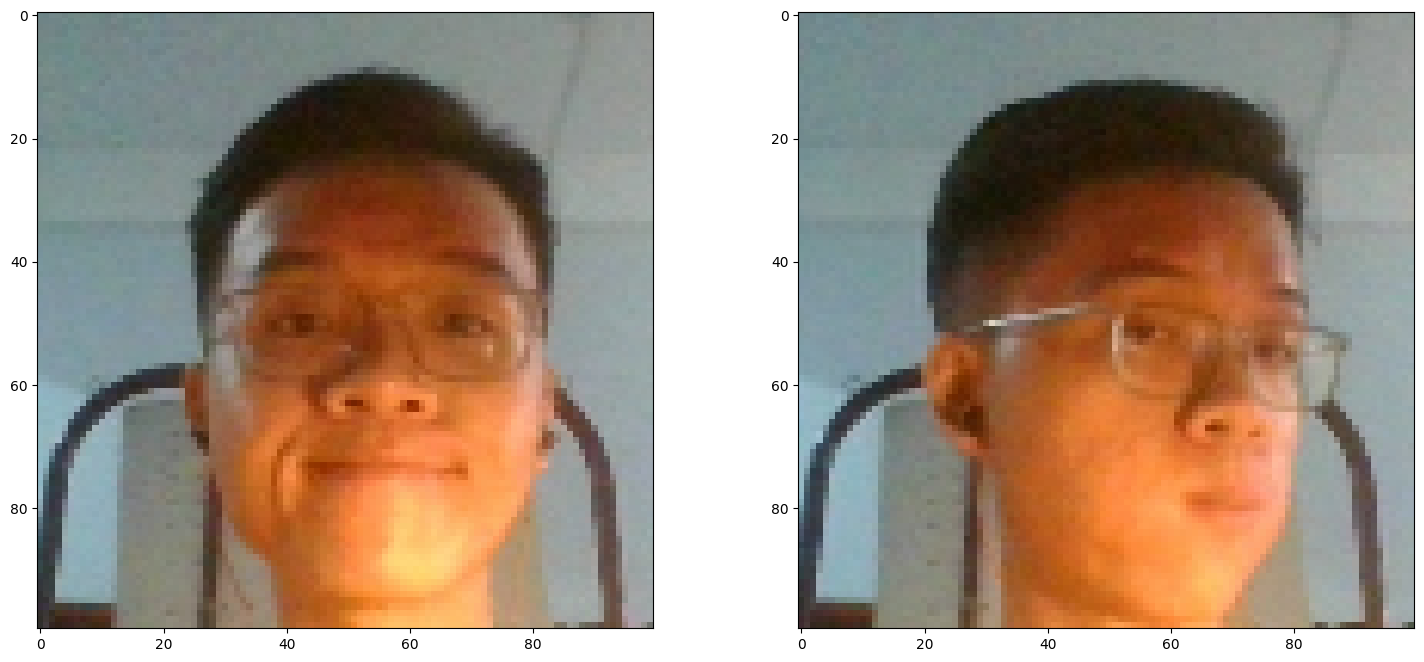

In [1223]:
plt.figure(figsize=(18, 8))  
plt.subplot(1, 2, 1)
plt.imshow(test_input[1])
plt.subplot(1, 2, 2)
plt.imshow(test_val[1])
plt.show()

SAVE MODEL

In [1224]:
# Save weights 
siamese_model.save('siamesemodel.h5')

In [1225]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [1227]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


array([[0.4984741 ],
       [0.49998412],
       [0.49981186],
       [0.49880815],
       [0.49905106],
       [0.49845272],
       [0.49782026],
       [0.49934506],
       [0.49924245],
       [0.4999337 ],
       [0.49887714],
       [0.4990977 ],
       [0.4994607 ],
       [0.4979031 ],
       [0.49834633],
       [0.49915746]], dtype=float32)

In [1228]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_51 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_51[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)